# Numbers

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2

In [4]:
# Načtení MNIST datasetu (číslice 0–9, 28x28 px)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Dataset obsahuje 70000 obrázků o velikosti 28x28 px


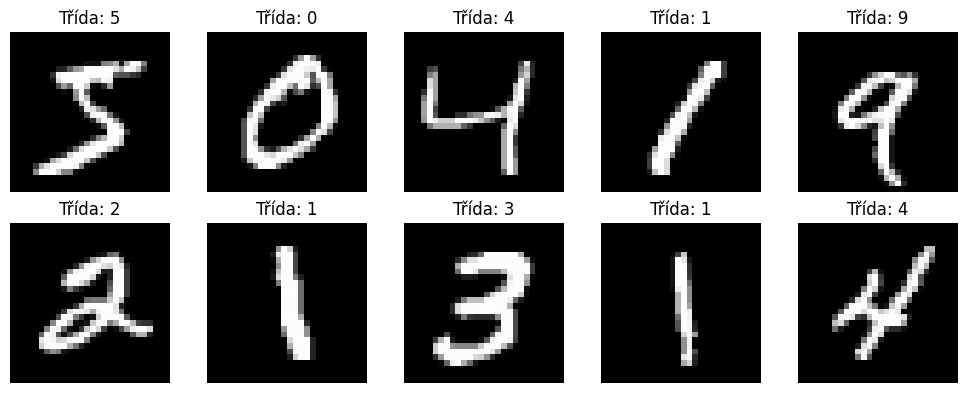

Počet obrázků v každé třídě:
0: 6903
1: 7877
2: 6990
3: 7141
4: 6824
5: 6313
6: 6876
7: 7293
8: 6825
9: 6958


In [5]:
# Spojení dat kvůli následnému vlastnímu rozdělení
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

print(f"Dataset obsahuje {X.shape[0]} obrázků o velikosti {X.shape[1]}x{X.shape[2]} px")

plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i], cmap='gray')
    plt.title(f"Třída: {y[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

counter = Counter(y)
print("Počet obrázků v každé třídě:")
for label, count in sorted(counter.items()):
    print(f"{label}: {count}")

In [6]:
unique_shapes = {img.shape for img in X}
print("Unikátní velikosti obrázků:", unique_shapes)

# V našem případě je dataset MNIST, všechny obrázky jsou 28x28, takže resize není třeba

# 🧼 Normalizace pixelových hodnot (z 0–255 na 0–1)
X = X.astype("float32") / 255.0

# 🧱 Přidání kanálové dimenze (pro CNN potřebujeme tvar [vzor, výška, šířka, kanály])
X = np.expand_dims(X, axis=-1)  # nyní tvar [n, 28, 28, 1]

# 🏷️ One-hot encoding labelů (čísel 0–9)
y_cat = to_categorical(y, num_classes=10)

# 📤 Rozdělení datasetu: 60 % trénink, 20 % validace, 20 % test
X_temp, X_test, y_temp, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=np.argmax(y_temp, axis=1))

# 📈 Výpis výsledných velikostí
print(f"Trénovací sada: {X_train.shape[0]} vzorků")
print(f"Validační sada: {X_val.shape[0]} vzorků")
print(f"Testovací sada: {X_test.shape[0]} vzorků")

Unikátní velikosti obrázků: {(28, 28)}
Trénovací sada: 42000 vzorků
Validační sada: 14000 vzorků
Testovací sada: 14000 vzorků


In [9]:
model = Sequential()

# Konvoluční blok 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Konvoluční blok 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Převedení na 1D vektor
model.add(Flatten())

# Skrytá hustá vrstva
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout kvůli přeučení

# Výstupní vrstva (klasifikace do 10 tříd)
model.add(Dense(10, activation='softmax'))

# 🧾 Souhrn modelu
model.summary()

c:\Users\marek\Documents\dev\python\Analyza_signalu2\ukoly\ukol5\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ⏱️ Early stopping – zastaví trénink, pokud se validační ztráta nezlepší
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 🏃‍♂️ Spuštění trénování
history = model.fit(X_train, y_train,
                    epochs=15,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Epoch 1/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7556 - loss: 0.7653 - val_accuracy: 0.9701 - val_loss: 0.0916
Epoch 2/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9658 - loss: 0.1183 - val_accuracy: 0.9823 - val_loss: 0.0572
Epoch 3/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9748 - loss: 0.0835 - val_accuracy: 0.9828 - val_loss: 0.0560
Epoch 4/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9826 - loss: 0.0594 - val_accuracy: 0.9863 - val_loss: 0.0453
Epoch 5/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9839 - loss: 0.0517 - val_accuracy: 0.9877 - val_loss: 0.0415
Epoch 6/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9874 - loss: 0.0403 - val_accuracy: 0.9869 - val_loss: 0.0415
Epoch 7/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9878 - loss: 0.0371 - val_accuracy: 0.9874 - val_loss: 0.0410
Epoch 8/15
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.9908 - loss: 0.0316 - val_accu

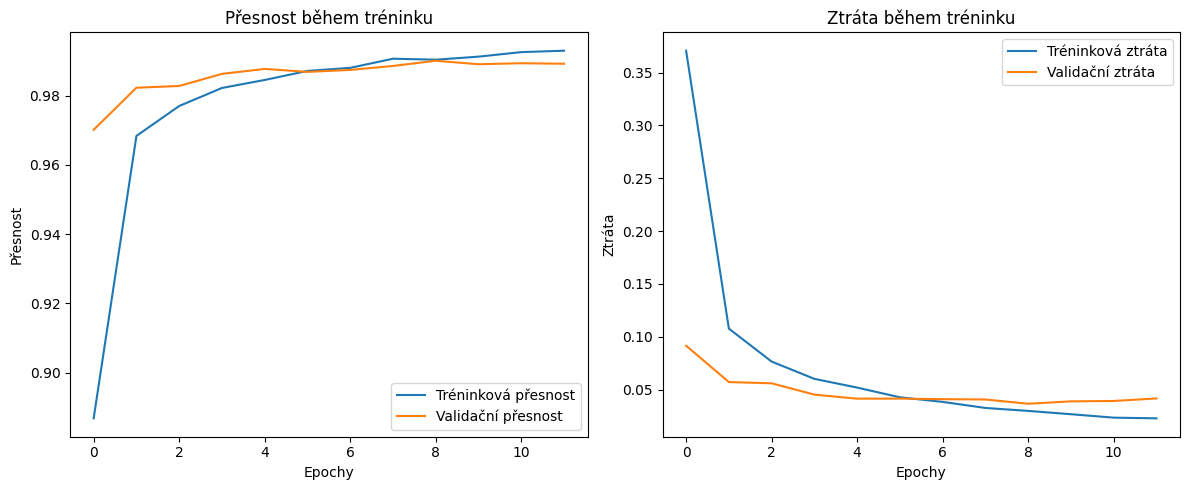

In [12]:
# 📊 Vykreslení průběhu přesnosti a ztráty
plt.figure(figsize=(12, 5))

# Přesnost
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Tréninková přesnost')
plt.plot(history.history['val_accuracy'], label='Validační přesnost')
plt.title('Přesnost během tréninku')
plt.xlabel('Epochy')
plt.ylabel('Přesnost')
plt.legend()

# Ztráta
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Tréninková ztráta')
plt.plot(history.history['val_loss'], label='Validační ztráta')
plt.title('Ztráta během tréninku')
plt.xlabel('Epochy')
plt.ylabel('Ztráta')
plt.legend()

plt.tight_layout()
plt.show()


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Klasifikační report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1381
           1       0.99      0.99      0.99      1575
           2       0.99      0.99      0.99      1398
           3       1.00      0.99      0.99      1428
           4       0.99      0.99      0.99      1365
           5       0.99      0.99      0.99      1263
           6       0.99      0.99      0.99      1375
           7       0.99      0.99      0.99      1459
           8       0.98      0.99      0.99      1365
           9       0.99      0.98      0.98      1391

    accuracy                           0.99     14000
   macro avg       0.99      0.99      0.99     14000
weighted avg       0.99      0.99      0.99     14000



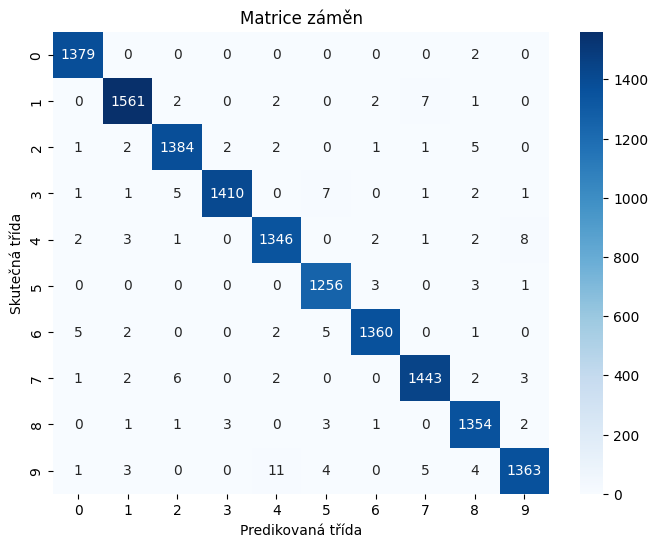

In [15]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# 📋 Report přesnosti
print("Klasifikační report:")
print(classification_report(y_true, y_pred))

# 🔲 Matici záměn
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice záměn')
plt.xlabel('Predikovaná třída')
plt.ylabel('Skutečná třída')
plt.show()

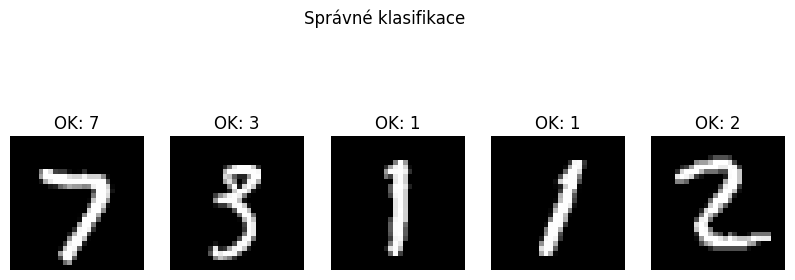

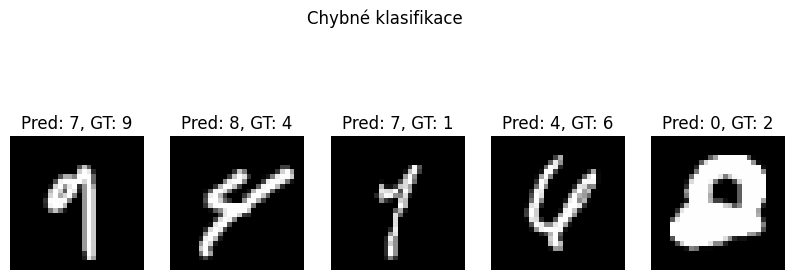

In [16]:
# Správně klasifikované
correct = np.where(y_pred == y_true)[0]
incorrect = np.where(y_pred != y_true)[0]

# 🟩 Správně klasifikované obrázky
plt.figure(figsize=(10, 4))
for i, idx in enumerate(correct[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"OK: {y_pred[idx]}")
    plt.axis("off")
plt.suptitle("Správné klasifikace")
plt.show()

# 🟥 Chybně klasifikované obrázky
plt.figure(figsize=(10, 4))
for i, idx in enumerate(incorrect[:5]):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {y_pred[idx]}, GT: {y_true[idx]}")
    plt.axis("off")
plt.suptitle("Chybné klasifikace")
plt.show()


In [18]:
learning_rates = [0.01, 0.001, 0.0001]
results = {}

for lr in learning_rates:
    print(f"\n🔧 Trénuji s learning_rate = {lr}")
    
    model_tune = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    model_tune.compile(optimizer=Adam(learning_rate=lr),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
    
    history_tune = model_tune.fit(X_train, y_train,
                                  validation_data=(X_val, y_val),
                                  epochs=10,
                                  batch_size=128,
                                  verbose=0)
    
    val_acc = history_tune.history['val_accuracy'][-1]
    print(f"Validační přesnost: {val_acc:.4f}")
    results[lr] = val_acc



🔧 Trénuji s learning_rate = 0.01


c:\Users\marek\Documents\dev\python\Analyza_signalu2\ukoly\ukol5\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validační přesnost: 0.9779

🔧 Trénuji s learning_rate = 0.001
Validační přesnost: 0.9859

🔧 Trénuji s learning_rate = 0.0001
Validační přesnost: 0.9776
